In [36]:
import pandas as pd
import numpy as np
from ultralytics import YOLO
import cv2
import json
import os
import matplotlib.pyplot as plt
import ast

In [37]:
def convert_to_list(string):
    return ast.literal_eval(string)

with open('data/basketball-positions.json', 'r') as f:
    basketball_data = json.load(f)
player_df = pd.read_csv('player_positions.csv', converters={'bounding_boxes': convert_to_list, 'xyz_positions': convert_to_list})

In [38]:
no_court_count = 0

def get_file_contents(filename):
    directories = [
        'datasets/yolo-basketball-data/train/labels/',
        'datasets/yolo-basketball-data/val/labels/'
    ]
    
    for directory in directories:
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                return file.read()
    return None

court_segment_model = YOLO('models/court_obb_model.onnx', task='obb')

def get_court_lines(filename, flip=False):
    global no_court_count
    directories = [
        'datasets/yolo-basketball-data/train/images/',
        'datasets/yolo-basketball-data/val/images/'
    ]
    filename = filename[:-4] + ".png"
    for directory in directories:
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            img = cv2.imread(file_path)
            img_height, img_width, _ = img.shape
            if flip:
                img = cv2.flip(img, 1)
            results = court_segment_model(img)
            if results[0].obb.xywhr.shape[0] == 0:
                no_court_count += 1
                return None
            court = np.array(results[0].obb.xywhr[0])
            return [court[0] / img_width, court[1] / img_height, court[2] / img_width, court[3] / img_height, court[4]]
    return None

basketball_position_data = []
for timestamp in basketball_data:
    if timestamp['annotations'][0]['visible']:
        filename1 = 'camcourt1_' + str(timestamp['timestamp']) + '_' + '0.txt'
        filename2 = 'camcourt2_' + str(timestamp['timestamp']) + '_' + '0.txt'
        bounding_box = get_file_contents(filename1)
        court_lines = get_court_lines(filename1)
        if not bounding_box is None and not court_lines is None:
            box_parts = bounding_box.split()
            basketball_position_data.append({
                'box_x': float(box_parts[1]),
                'box_y': float(box_parts[2]),
                'box_width': float(box_parts[3]),
                'box_height': float(box_parts[4]),
                'court_x': float(court_lines[0]),
                'court_y': float(court_lines[1]),
                'court_w': float(court_lines[2]),
                'court_h': float(court_lines[3]),
                'court_r': float(court_lines[4]),
                'x_pos': timestamp['annotations'][0]['center'][0],
                'y_pos': timestamp['annotations'][0]['center'][1],
                'z_pos': timestamp['annotations'][0]['center'][2]
            })
        bounding_box = get_file_contents(filename2)
        court_lines = get_court_lines(filename2, flip=True)
        if not bounding_box is None and not court_lines is None:
            box_parts = bounding_box.split()
            basketball_position_data.append({
                'box_x': 1 - float(box_parts[1]),
                'box_y': float(box_parts[2]),
                'box_width': float(box_parts[3]),
                'box_height': float(box_parts[4]),
                'court_x': float(court_lines[0]),
                'court_y': float(court_lines[1]),
                'court_w': float(court_lines[2]),
                'court_h': float(court_lines[3]),
                'court_r': float(court_lines[4]),
                'x_pos': 2800 - timestamp['annotations'][0]['center'][0],
                'y_pos': timestamp['annotations'][0]['center'][1],
                'z_pos': timestamp['annotations'][0]['center'][2]
            })
for idx, row in player_df.iterrows():
    file_path = row['filepath']
    img = cv2.imread(file_path)
    img_height, img_width, _ = img.shape
    results = court_segment_model(file_path)
    court_lines = None
    if results[0].obb.xywhr.shape[0] == 0:
        no_court_count += 1
        court_lines = None
    else:
        court = np.array(results[0].obb.xywhr[0])
        court_lines = [court[0] / img_width, court[1] / img_height, court[2] / img_width, court[3] / img_height, court[4]]
    
    for i in range(len(row['bounding_boxes'])):
        bounding_box = row['bounding_boxes'][i]
        if not bounding_box is None and not court_lines is None:
            basketball_position_data.append({
                'box_x': float(bounding_box[0]),
                'box_y': float(bounding_box[1]),
                'box_width': float(bounding_box[2]),
                'box_height': float(bounding_box[3]),
                'court_x': float(court_lines[0]),
                'court_y': float(court_lines[1]),
                'court_w': float(court_lines[2]),
                'court_h': float(court_lines[3]),
                'court_r': float(court_lines[4]),
                'x_pos': float(row['xyz_positions'][i][0]),
                'y_pos': float(row['xyz_positions'][i][1]),
                'z_pos': float(row['xyz_positions'][i][2])
            })
basketball_position_data = pd.DataFrame(basketball_position_data)

Loading models\court_obb_model.onnx for ONNX Runtime inference...

0: 640x640 63.7ms
Speed: 6.9ms preprocess, 63.7ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 58.3ms
Speed: 4.5ms preprocess, 58.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 55.4ms
Speed: 4.0ms preprocess, 55.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 58.2ms
Speed: 2.9ms preprocess, 58.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 54.9ms
Speed: 3.0ms preprocess, 54.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 59.2ms
Speed: 3.6ms preprocess, 59.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 60.6ms
Speed: 3.9ms preprocess, 60.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 61.7ms
Speed: 5.8ms preprocess, 61.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

In [39]:
print(f"Number of images with no court detected: {no_court_count}")

Number of images with no court detected: 11


In [40]:
basketball_position_data

,box_x,box_y,box_width,box_height,court_x,court_y,court_w,court_h,court_r,x_pos,y_pos,z_pos
0,0.364512,0.266838,0.013271,0.015411,0.493480,0.540316,0.847164,0.561694,0.123939,177.289941,669.812214,-256.679564
1,0.354024,0.402683,0.010274,0.013128,0.490774,0.540144,0.866896,0.564007,0.106092,126.558866,706.482751,-15.172560
2,0.489726,0.377854,0.012842,0.017123,0.483788,0.549621,0.867674,0.581854,0.124405,535.783127,755.060091,-140.640071
3,0.638057,0.549658,0.014983,0.020548,0.476192,0.548533,0.854675,0.578726,0.136375,958.676103,1081.954716,-64.657048
4,0.273973,0.348459,0.010274,0.014269,0.482233,0.546732,0.860506,0.577815,0.135868,-108.094570,658.629903,-119.536335
...,...,...,...,...,...,...,...,...,...,...,...,...
2542,0.312500,0.547002,0.041256,0.136143,0.480615,0.689823,0.822820,0.425181,3.073814,174.544308,745.209749,-180.000000
2543,0.293411,0.561994,0.075739,0.174230,0.480615,0.689823,0.822820,0.425181,3.073814,180.501435,849.779985,-180.000000
2544,0.378387,0.532820,0.043719,0.138574,0.480615,0.689823,0.822820,0.425181,3.073814,279.224455,659.764764,-180.000000
2545,0.629310,0.482577,0.032020,0.120746,0.480615,0.689823,0.822820,0.425181,3.073814,711.748766,330.865382,-180.000000


In [41]:
basketball_position_data.to_csv('position_features.csv', index=False)

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [43]:
df = pd.read_csv('position_features.csv')

In [44]:
df['x_pos'] = df['x_pos'] / 1400
df['y_pos'] = df['y_pos'] / 1500

In [45]:
class BasketballDataset(Dataset):
    def __init__(self, df, input_columns, target_columns, transform=None):
        self.data = df[input_columns].values
        self.targets = df[target_columns].values
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        if self.transform:
            x = self.transform(x)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [46]:
input_columns = ['box_x', 'box_y', 'box_width', 'box_height', 
                 'court_x', 'court_y', 'court_w', 'court_h', 
                 'court_r']
target_columns = ['x_pos', 'y_pos']

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=86)

# Create Datasets and DataLoaders
train_dataset = BasketballDataset(train_df, input_columns, target_columns)
test_dataset = BasketballDataset(test_df, input_columns, target_columns)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [47]:
class BasketballNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(BasketballNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 24)
        self.fc3 = nn.Linear(24, 16)
        self.fc4 = nn.Linear(16, output_size)

        self.relu = nn.ReLU()
        self.elu = nn.ELU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
model = BasketballNet(input_size=len(input_columns), output_size=len(target_columns))

In [48]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [49]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')


Epoch 1/100, Loss: 0.1509
Epoch 2/100, Loss: 0.0785
Epoch 3/100, Loss: 0.0753
Epoch 4/100, Loss: 0.0702
Epoch 5/100, Loss: 0.0589
Epoch 6/100, Loss: 0.0432
Epoch 7/100, Loss: 0.0366
Epoch 8/100, Loss: 0.0320
Epoch 9/100, Loss: 0.0290
Epoch 10/100, Loss: 0.0281
Epoch 11/100, Loss: 0.0267
Epoch 12/100, Loss: 0.0259
Epoch 13/100, Loss: 0.0251
Epoch 14/100, Loss: 0.0245
Epoch 15/100, Loss: 0.0238
Epoch 16/100, Loss: 0.0236
Epoch 17/100, Loss: 0.0231
Epoch 18/100, Loss: 0.0230
Epoch 19/100, Loss: 0.0229
Epoch 20/100, Loss: 0.0225
Epoch 21/100, Loss: 0.0219
Epoch 22/100, Loss: 0.0218
Epoch 23/100, Loss: 0.0219
Epoch 24/100, Loss: 0.0219
Epoch 25/100, Loss: 0.0217
Epoch 26/100, Loss: 0.0217
Epoch 27/100, Loss: 0.0215
Epoch 28/100, Loss: 0.0213
Epoch 29/100, Loss: 0.0215
Epoch 30/100, Loss: 0.0216
Epoch 31/100, Loss: 0.0213
Epoch 32/100, Loss: 0.0212
Epoch 33/100, Loss: 0.0212
Epoch 34/100, Loss: 0.0212
Epoch 35/100, Loss: 0.0210
Epoch 36/100, Loss: 0.0212
Epoch 37/100, Loss: 0.0208
Epoch 38/1

In [50]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')


Test Loss: 0.0215


In [51]:
input_tensor = torch.tensor(df.iloc[0, :-3].to_numpy(), dtype=torch.float32).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)

predicted_xyz = output.squeeze().numpy()
predicted_xyz

array([    0.10673,     0.33766], dtype=float32)

In [52]:
df.mean()

box_x           0.568937
box_y           0.471633
box_width       0.037195
box_height      0.101057
court_x         0.507264
court_y         0.579328
court_w         0.799019
court_h         0.451720
court_r         1.174014
x_pos           0.470587
y_pos           0.480662
z_pos        -173.371223
dtype: float64

In [58]:
torch.save(model.state_dict(), "models/position_model.pth")

In [ ]:
import torch.onnx

model.eval()
dummy_input = torch.randn(1, 9)
torch.onnx.export(model, 
                  dummy_input,
                  "models/position_model.onnx", 
                  export_params=True, 
                  opset_version=13,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'])

In [54]:
import onnxruntime as ort

In [59]:
session = ort.InferenceSession('models/position_model.onnx')
player_model = YOLO('models/player_detect_model.onnx', task='detect')
court_model = YOLO('models/court_obb_model.onnx', task='obb')
bball_model = YOLO('models/bball_detect_model.onnx', task='detect')

def predict(img):
    cv2_img = cv2.imread(img)
    height, width, _ = cv2_img.shape
    player_results = player_model(img)
    player_results = player_results[0].boxes.xywh
    if player_results.shape[0] == 0:
        player_results = None

    bball_results = bball_model(img)
    bball_results = bball_results[0].boxes.xywh

    default_court = np.array([[0.508744, 0.580394, 0.798212, 0.452258, 1.333351]])
    court_results = court_model(img)
    court_results = court_results[0].obb.xywhr
    if court_results.shape[0] == 0:
        court_results = default_court
    else:
        court_results = court_results.numpy()
        court_results[:, [0, 2]] /= width
        court_results[:, [1, 3]] /= height
    
    inputs_to_final_model = []

    # Combine each output from output1 with output3
    if bball_results.shape[0] > 0:
        bball_results = bball_results.numpy()
        bball_results[:, [0, 2]] /= width
        bball_results[:, [1, 3]] /= height
        for i in range(bball_results.shape[0]):
            combined_input = np.concatenate((bball_results[i], np.squeeze(court_results, axis=0)), axis=0)
            inputs_to_final_model.append(combined_input)

    # Combine each output from output2 with output3
    if player_results is not None:
        player_results = player_results.numpy()
        player_results[:, [0, 2]] /= width
        player_results[:, [1, 3]] /= height
        for i in range(player_results.shape[0]):
            combined_input = np.concatenate((player_results[i], np.squeeze(court_results, axis=0)), axis=0)
            inputs_to_final_model.append(combined_input)

    # Stack the inputs for batch prediction
    if inputs_to_final_model:
        final_inputs = np.stack(inputs_to_final_model)
    else:
        final_inputs = np.empty((0, 9))  # In case there are no valid inputs
    
    if final_inputs.shape[0] > 0:
        inputs = {session.get_inputs()[0].name: final_inputs}
        final_outputs = session.run(None, inputs)[0].tolist()
    else:
        final_outputs = None

    return {'prediction': final_outputs, 'bballs': bball_results.shape[0]}

In [60]:
result = predict('data/KS-FR-BLOIS/24330/camcourt1_1513711368928_0.png')

Loading models\player_detect_model.onnx for ONNX Runtime inference...

image 1/1 c:\Users\Jeffrey\Basketball-Player-Tracking\data\KS-FR-BLOIS\24330\camcourt1_1513711368928_0.png: 640x640 12 players, 411.0ms
Speed: 4.4ms preprocess, 411.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Loading models\bball_detect_model.onnx for ONNX Runtime inference...

image 1/1 c:\Users\Jeffrey\Basketball-Player-Tracking\data\KS-FR-BLOIS\24330\camcourt1_1513711368928_0.png: 640x640 1 basketball, 409.3ms
Speed: 4.0ms preprocess, 409.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Loading models\court_obb_model.onnx for ONNX Runtime inference...

image 1/1 c:\Users\Jeffrey\Basketball-Player-Tracking\data\KS-FR-BLOIS\24330\camcourt1_1513711368928_0.png: 640x640 66.8ms
Speed: 3.0ms preprocess, 66.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


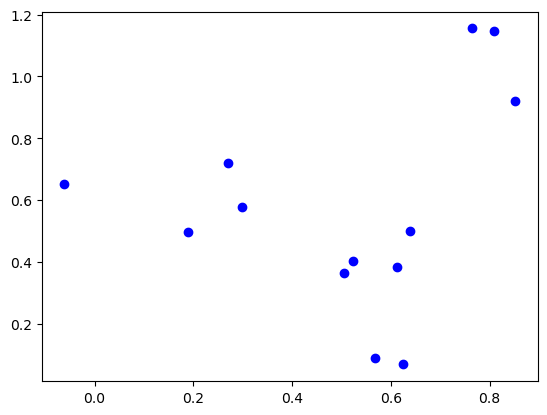

In [62]:
coordinates = np.array(result['prediction'])

x_coords = [coord[0] for coord in coordinates]
y_coords = [coord[1] for coord in coordinates]

plt.scatter(x_coords, y_coords, color='blue')
plt.show()